In [3]:
import keras.layers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
from os import *
import matplotlib.pyplot as plt
import matplotlib.image as imshow
from scipy.misc import imread
from sklearn.utils import shuffle
from skimage.transform import rescale
import os


def listdir(path):
    l = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            l.append(f)
    return l

print('Sucessfully imported all modules')

Sucessfully imported all modules


In [4]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.4/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=[conv2d_1/...)`


27430209

In [5]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    #path to data folder
    #shape - shape of the images
    def __init__(self,path,shape):
        self.data = {}
        self.categories = {}
        self.w,self.h = shape
        #self.n_val,self.n_ex_val,_,_ = self.data['val'].shape
        self.path = path

        
    def load_rnd_image(self, category, data_path):
        category_path = os.path.join(data_path, category)
        try:
            idx = rng.randint(len(listdir(category_path)))
        except ValueError:
            print(category)
            print(data_path)
        example = listdir(category_path)[idx]
        example_path = os.path.join(category_path, example)
        return rescale(imread(example_path,mode = 'RGB'), 0.4347)#/255 #TODO: Remove reshape
        
        
    def get_batch(self,n,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        data_path = os.path.join(self.path,s)
        n_classes = len(listdir(data_path))
        #select random categories by name
        categories_names = np.array(listdir(data_path))
        categories_n = rng.choice(n_classes,size=(n,),replace=False)
        categories = categories_names[categories_n]
        pairs=[np.zeros((n, self.h, self.w, 3), dtype = np.float32) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            category_n = categories_n[i]
            pairs[0][i,:,:,:] = self.load_rnd_image(category, data_path)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else categories_names[(category_n + rng.randint(1,n_classes-1)) % n_classes]
            pairs[1][i,:,:,:] = self.load_rnd_image(category_2, data_path)
        return pairs, targets
    
    
    def make_oneshot_task(self,N,s='val', verbose = False):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        data_path = os.path.join(self.path,s)
        n_classes = len(listdir(data_path))
        #get list of category names
        categories_names = np.array(listdir(data_path))
        #select random numbers for rnadom category selection 
        categories_n = rng.choice(n_classes,size=(N,),replace=False)
        #select random category names
        categories = categories_names[categories_n]
        true_category = categories[0]
        if verbose:
            print('True cateogry', ' : ' ,true_category)
        test_image = np.asarray([self.load_rnd_image(true_category, data_path)]*N).reshape(N,self.w,self.h,3)
        support_set = np.zeros((N, self.w, self.h, 3))
        for i in range(1,N):
            if verbose:
                print(i,' : ',categories[i])
            support_set[i,:,:,:] = self.load_rnd_image(categories[i], data_path)
        support_set[0,:,:] = self.load_rnd_image(true_category, data_path)
        support_set = support_set.reshape(N,self.w,self.h,3)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]
        return pairs, targets

    
    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    

loader = Siamese_Loader(path = '', shape = (100,100))
print('Created the Loader object')

Created the Loader object


In [6]:
batch_size = 32
print('Test loading batch of size:' + str(batch_size), flush=True)
(inputs, targets) = loader.get_batch(batch_size)
print('Batch function working')

Test loading batch of size:32


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Batch function working


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(100, 100, 3)


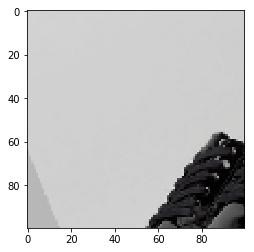

[[[[  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   [  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   [  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   ..., 
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]]

  [[  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   [  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   [  8.82352948e-01   8.82352948e-01   8.82352948e-01]
   ..., 
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]]

  [[  8.78431380e-01   8.78431380e-01   8.78431380e-01]
   [  8.78431380e-01   8.78431380e-01   8.78431380e-01]
   [  8.78431380e-01   8.78431380e-01   8.78431380e-01]
   ..., 
   [  8.66666675e-01   8.66666675e-01   8.66666675e-01]
   [  8.66470575e-01   8.66470575e-01   8.66470575e-01]
   [  8.62745106e

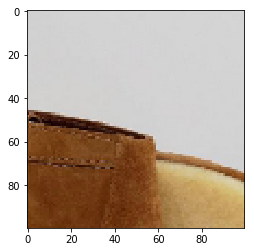

0.0

In [7]:
len(inputs)
print(targets)
i = 1
print(inputs[0][i].shape)
plt.imshow(inputs[0][i])
plt.show()
print(inputs[0])
              
              
print(inputs[1][i].shape)
plt.imshow(inputs[1][i])
plt.show()
              
              
targets[3]

In [8]:
(val_inputs, val_targets) = loader.make_oneshot_task(N=3, verbose = True)
print(val_targets)


True cateogry  :  9e94e86e-6793-11e7-81ab-42010a8e0002
1  :  9c28a574-673f-11e7-81ab-42010a8e0002
2  :  36247f46-673a-11e7-81ab-42010a8e0002
[ 1.  0.  0.]


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


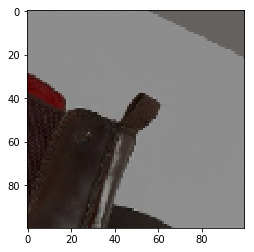

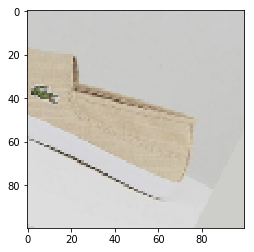

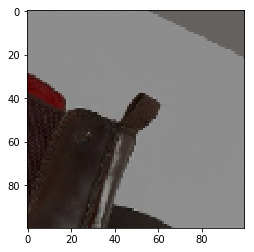

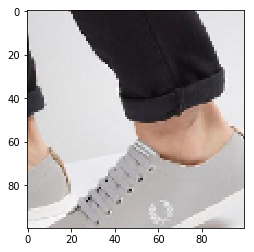

In [ ]:
plt.imshow(val_inputs[0][1])
plt.show()
plt.imshow(val_inputs[1][1])
plt.show()

val_targets[2]
plt.imshow(val_inputs[0][2])
plt.show()
plt.imshow(val_inputs[1][2])
plt.show()

In [ ]:
#Training loop
evaluate_every = 2000
loss_every=50
batch_size = 32
N_way = 20
n_val = 250
#siamese_net.load_weights("/home/soren/keras-oneshot/weights")
max_epochs = 100
for i in range(1,max_epochs):
    print(i)
    (inputs,targets)=loader.get_batch(batch_size)
    print('Received batch')
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        print('Testing accuracy')
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save('/weights')
            with open('result.txt', 'w') as f:
                f.write(val_acc)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        


1


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Received batch
2


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Received batch
3
Received batch
4
Received batch
5
Received batch
6
Received batch
7
Received batch
8
Received batch
9
Received batch
10
Received batch
11
Received batch
12
Received batch
13
Received batch
14
Received batch
15
Received batch
16
Received batch
17
Received batch
18
Received batch
19
Received batch
20
Received batch
21
Received batch
22
Received batch
23
Received batch
24
Received batch
25
Received batch
26
Received batch
27
Received batch
28
Received batch
29
Received batch
30
Received batch
31
Received batch
32
Received batch
33
Received batch
34
Received batch
35
Received batch
36
Received batch


In [ ]:
def nearest_neighbour(pairs,targets):
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour(pairs,targets)
        n_right+= correct
    return 100.0 * n_right / n_trials


siamese_net.load_weights("/home/soren/keras-oneshot/weights")
ways = np.arange(1,60,2)
val_accs, train_accs,nn_accs = [],[],[]
print("?")
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net,N,trials,"val",verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net,N,trials,"train",verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials,loader))
import seaborn as sns
plt.plot(ways,val_accs,"m")
plt.plot(ways,train_accs,"y")
plt.plot(ways,nn_accs,"c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)